challenge 4 (crimen en la libreria SQL):    

In [2]:
# ------- almacen de datos ------
authors_books = []

In [3]:
# ------- funciones importantes -------

import requests
import time


# ----- funcion para hacer request a los url  ------
def hacer_requests(URL, params=None):
    reintentos_posibles = 5
    tiempo_espera = 1
    
    time.sleep(tiempo_espera)
    for intentos in range(reintentos_posibles):
        try:
            respuesta = requests.get(URL, params=params)
            return respuesta
        except:
            print(f"[error de conexion] : [intento {intentos + 1}] : [tiempo de espera : {tiempo_espera}]")
            time.sleep(tiempo_espera)
            tiempo_espera *= 2
    
    return None

In [4]:
# ------- Escraper en si -------

from bs4 import BeautifulSoup
from urllib import parse

# ----- URL a usar ------
url_booksToScrape = "https://books.toscrape.com/index.html"
url_api_googleBooks = "https://www.googleapis.com/books/v1/volumes"

# ----- hacer conexion y soup ------
respuesta = hacer_requests(url_booksToScrape)
soup = BeautifulSoup(respuesta.content, "lxml")

# ------ recoger todas las categorias -----
side_categories_tag = soup.find("div", class_="side_categories")
nav_list_tag = side_categories_tag.find("ul", class_="nav nav-list")
ubication_categories_tag = nav_list_tag.find("ul")
list_all_categories_tag = ubication_categories_tag.find_all("li")

for elemento in list_all_categories_tag:
    
    # ------- nombre de la categoria --------
    category_name = elemento.a.get_text(strip=True)
    # ----------------------------------------

    print(category_name)

    category_reference_url = elemento.a["href"]

    new_url = parse.urljoin(url_booksToScrape, category_reference_url)
    response = hacer_requests(new_url)
    category_scan = True

    while category_scan:
        category_eleccion_soup = BeautifulSoup(response.content, "lxml")

        # --------- encontrar todos los libros de la categoria --------
        div_tag = category_eleccion_soup.find("div", class_="col-sm-8 col-md-9")
        section_tag = div_tag.find("section")
        ol_tag = section_tag.find("ol", class_="row")
        
        list_of_books_tags = ol_tag.find_all("article", class_="product_pod")

        for book in list_of_books_tags:

            # ------- nombre del libro ----------
            book_name = book.div.a.img["alt"]
            # -----------------------------------

            # proceso para obtener autores
            params = {
                "q" : f"intitle:{book_name}"
            }

            try:
                response_api = hacer_requests(url_api_googleBooks, params)
                data = response_api.json()
                items = data["items"][0]
                volume_info = items["volumeInfo"]

                # --------- autores del libro ----------
                authors = volume_info.get("authors", [])
                # --------------------------------------

                if len(authors) == 0:
                    # por si la lista es vacia
                    authors = ["none"]

            except:
                # por si google me deniega
                authors = ['none']

            # ------ cantidad de estrellas ------
            stars = book.p["class"][1]
            # -----------------------------------

            product_price_tag = book.find("div", class_="product_price")

            # ------ precio del libro ---------------------
            price = product_price_tag.p.get_text(strip=True)
            # ----------------------------------------------

            p_tag = product_price_tag.find("p", class_="instock availability")

            # ------- si el libro esta en stock ------------
            in_stock = p_tag.get_text(strip=True)
            # ----------------------------------------------

            authors_books.append((category_name, {
                "title" : book_name,
                "authors" : authors,
                "stars" : stars,
                "price" : price,
                "stock" : in_stock
            }))
            print(f"[agregado] : [book : {book_name}] : [author : {authors}]")
        
        next_tag = section_tag.find("li", class_="next")
        
        if next_tag:
            next_url = next_tag.a["href"]
            next_page_url = parse.urljoin(new_url, next_url)
            print(f"[next page : {category_name}]")
            response = hacer_requests(next_page_url)
            continue

        break





    


Travel
[agregado] : [book : It's Only the Himalayas] : [author : ['S. Bedford']]
[agregado] : [book : Full Moon over Noah’s Ark: An Odyssey to Mount Ararat and Beyond] : [author : ['Rick Antonson']]
[agregado] : [book : See America: A Celebration of Our National Parks & Treasured Sites] : [author : ['none']]
[agregado] : [book : Vagabonding: An Uncommon Guide to the Art of Long-Term World Travel] : [author : ['Rolf Potts']]
[agregado] : [book : Under the Tuscan Sun] : [author : ['Frances Mayes']]
[agregado] : [book : A Summer In Europe] : [author : ['Mary Elizabeth Blake']]
[agregado] : [book : The Great Railway Bazaar] : [author : ['Paul Theroux']]
[agregado] : [book : A Year in Provence (Provence #1)] : [author : ['Peter Mayle']]
[agregado] : [book : The Road to Little Dribbling: Adventures of an American in Britain (Notes From a Small Island #2)] : [author : ['Bill Bryson']]
[agregado] : [book : Neither Here nor There: Travels in Europe] : [author : ['Bill Bryson']]
[agregado] : [bo

In [ ]:
#  -------- DATA BASE ----------

# CREATE TABLE IF NOT EXISTS Categories(
#     id INTEGER PRIMARY KEY AUTOINCREMENT,
#     category_name TEXT UNIQUE NOT NULL
# );

# CREATE TABLE IF NOT EXISTS Authors(
#     id INTEGER PRIMARY KEY AUTOINCREMENT,
#     name TEXT UNIQUE NOT NULL
# );

# CREATE TABLE IF NOT EXISTS Books(
#     id INTEGER PRIMARY KEY AUTOINCREMENT,
#     title TEXT NOT NULL,
#     price REAL,
#     stars TEXT,
#     stock TEXT,
#     id_category INTEGER,
#     FOREIGN KEY (id_category) REFERENCES categories(id)
#     );

# CREATE TABLE IF NOT EXISTS Books_authors(
#     id_book INTEGER,
#     id_author INTEGER,
#     PRIMARY KEY (id_book, id_author),
#     FOREIGN KEY (id_book) REFERENCES Books(id),
#     FOREIGN KEY (id_author) REFERENCES Authors(id)
# );

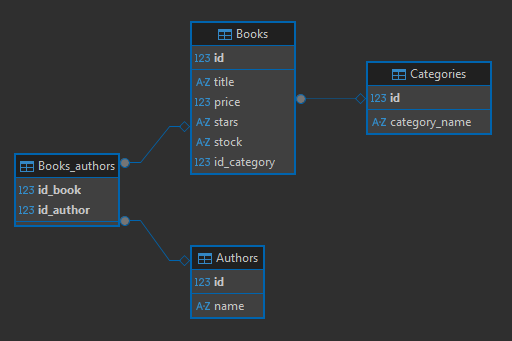

In [5]:
import sqlite3

conexion = sqlite3.connect("dataBase.db")
cursor = conexion.cursor()

cursor.execute("BEGIN")

for category, book in authors_books:

    cursor.execute("""INSERT OR IGNORE INTO Categories(category_name) VALUES (?)""", (category,))

    cursor.execute("SELECT id FROM Categories WHERE category_name = ?", (category,))

    category_id = cursor.fetchone()[0]

    # desempaquetar informacion del libro:
    title = book["title"]
    authors_book = book["authors"]
    stock = book["stock"]


    try:
        stars = ["Zero","One","Two","Three","Four","Five"].index(book["stars"].capitalize())
    except:
        stars = None

    price = float(book["price"].replace("£","").strip()) if "£" in book["price"] else None

    cursor.execute("INSERT OR IGNORE INTO Books(title, price, stars, stock, id_category) VALUES (?, ?, ?, ?, ?)", (title, price, stars, stock, category_id))

    cursor.execute("SELECT id FROM Books WHERE title = ?", (title,))

    book_id = cursor.fetchone()[0]

    for aut in authors_book:

        cursor.execute("INSERT OR IGNORE INTO Authors(name) VALUES (?)", (aut,))

        cursor.execute("SELECT id FROM Authors WHERE name = ?", (aut,))

        author_id = cursor.fetchone()[0]

        cursor.execute("INSERT OR IGNORE INTO Books_authors(id_book, id_author) VALUES (?, ?)", (book_id, author_id))

    print(f"[agregado] : {title}")

conexion.commit()
conexion.close()

[agregado] : It's Only the Himalayas
[agregado] : Full Moon over Noah’s Ark: An Odyssey to Mount Ararat and Beyond
[agregado] : See America: A Celebration of Our National Parks & Treasured Sites
[agregado] : Vagabonding: An Uncommon Guide to the Art of Long-Term World Travel
[agregado] : Under the Tuscan Sun
[agregado] : A Summer In Europe
[agregado] : The Great Railway Bazaar
[agregado] : A Year in Provence (Provence #1)
[agregado] : The Road to Little Dribbling: Adventures of an American in Britain (Notes From a Small Island #2)
[agregado] : Neither Here nor There: Travels in Europe
[agregado] : 1,000 Places to See Before You Die
[agregado] : Sharp Objects
[agregado] : In a Dark, Dark Wood
[agregado] : The Past Never Ends
[agregado] : A Murder in Time
[agregado] : The Murder of Roger Ackroyd (Hercule Poirot #4)
[agregado] : The Last Mile (Amos Decker #2)
[agregado] : That Darkness (Gardiner and Renner #1)
[agregado] : Tastes Like Fear (DI Marnie Rome #3)
[agregado] : A Time of Tormen

------ MOSTRAR TODOS LOS LIBROS CON SUS ESTRELLAS Y SUS AUTORES ------

In [ ]:
import pandas as pd
import sqlite3

conexion = sqlite3.connect("dataBase.db")

query = """
    SELECT 
        Books.title,
        Books.stars,
        GROUP_CONCAT(Authors.name, ", ") AS authors
    FROM Books
    JOIN Books_authors ON Books.id = Books_authors.id_book
    JOIN Authors ON Books_authors.id_author = Authors.id
    GROUP BY Books.title;
"""

df = pd.read_sql_query(query, conexion)

conexion.close()

display(df)

,title,stars,authors
0,"""Most Blessed of the Patriarchs"": Thomas Jeffe...",5,"Annette Gordon-Reed, Peter S. Onuf"
1,#GIRLBOSS,1,Libros Maestros
2,#HigherSelfie: Wake Up Your Life. Free Your So...,5,"Lucy Sheridan, Jo Westwood"
3,'Salem's Lot,4,Stephen King
4,(Un)Qualified: How God Uses Broken People to D...,5,Steven Furtick
...,...,...,...
994,Zealot: The Life and Times of Jesus of Nazareth,3,Reza Aslan
995,Zero History (Blue Ant #3),1,none
996,"Zero to One: Notes on Startups, or How to Buil...",3,"Peter Thiel, Blake Masters"
997,orange: The Complete Collection 1 (orange: The...,1,none


 ----- MOSTRAR TODOS LOS LIBROS QUE TENGAN TRES ESTRELLAS O MENOS ------

In [19]:
import pandas as pd
import sqlite3

conexion = sqlite3.connect("dataBase.db")

query = """
    SELECT 
        Books.title,
        Books.price,
        Books.stars
    FROM Books 
    WHERE Books.stars <= 3
    ORDER BY stars;
"""

pf = pd.read_sql_query(query, conexion)

conexion.close()

display(pf)

,title,price,stars
0,The Great Railway Bazaar,30.54,1
1,The Road to Little Dribbling: Adventures of an...,23.21,1
2,"In a Dark, Dark Wood",19.63,1
3,A Murder in Time,16.64,1
4,That Darkness (Gardiner and Renner #1),13.92,1
...,...,...,...
620,The Bone Hunters (Lexy Vaughan & Steven Macaul...,59.71,3
621,"Overload: How to Unplug, Unwind, and Unleash Y...",52.15,3
622,You Are a Badass: How to Stop Doubting Your Gr...,12.08,3
623,Silence in the Dark (Logan Point #4),58.33,3


-------- MOSTRAR LOS LIBROS QUE SON MAS ECONOMICOS ------

In [25]:
import pandas as pd
import sqlite3

conexion = sqlite3.connect("dataBase.db")

query = """
    SELECT 
        Books.title,
        Books.stars,
        GROUP_CONCAT(Authors.name, ", ") AS Authors,
        Books.price
    FROM Books
    INNER JOIN Books_authors ON 
        Books.id = Books_authors.id_book
    INNER JOIN Authors ON
        Books_authors.id_author = Authors.id
    WHERE Books.price < 13.0
    GROUP BY Books.title;
"""

df = pd.read_sql_query(query, conexion)

conexion.close()

display(df)

,title,stars,Authors,price
0,A Clash of Kings (A Song of Ice and Fire #2),3,George R. R. Martin,10.79
1,"Adulthood Is a Myth: A ""Sarah's Scribbles"" Col...",2,Sarah Andersen,10.90
2,Agnostic: A Spirited Manifesto,5,Lesley Hazleton,12.51
3,An Abundance of Katherines,5,John Green,10.00
4,Are We There Yet?,3,Dan Albert,10.66
...,...,...,...,...
58,The Third Wave: An Entrepreneur’s Vision of th...,5,Steve Case,12.61
59,The Tipping Point: How Little Things Can Make ...,2,none,10.02
60,Underlying Notes,2,Eva Pasco,11.82
61,Walt Disney's Alice in Wonderland,5,Teddy Slater,12.96


-------- MOSTRAR EL AUTOR CON MAS LIBROS CON MALOS ---------

In [54]:
import sqlite3
import pandas as pd

conexion = sqlite3.connect("dataBase.db")

query = """
    SELECT 
        COUNT(Books.title) AS Books,
        Authors.name,
        Books.stars
    FROM Books
    INNER JOIN Books_authors ON 
        Books.id = Books_authors.id_book
    INNER JOIN Authors ON
        Books_authors.id_author = Authors.id
    WHERE Books.stars = 1 
    GROUP BY Authors.name
    ORDER BY Books DESC
    LIMIT 2;
"""

df = pd.read_sql_query(query, conexion)

conexion.close()

display(df)

,Books,name,stars
0,21,none,1
1,2,Ransom Riggs,1


------ PRUEBA DE TIEMPO CON O SIN INDEX ------

In [ ]:
import time
import sqlite3

conexion = sqlite3.connect("dataBase.db")
cursor = conexion.cursor()

start = time.time()
cursor.execute("""
    SELECT
        Books.title,
        Books.stars
    FROM Books
    ORDER BY Books.stars;
""") 
cursor.fetchall()
print("sin indice: ", (start - time.time()))


cursor.execute("""
    CREATE INDEX IF NOT EXISTS idx_books_stars ON Books(stars);
""")
conexion.commit()

start = time.time()
cursor.execute("""
    SELECT
        Books.title,
        Books.stars
    FROM Books
    ORDER BY Books.stars;
""") 
cursor.fetchall()
print("con indice: ", (start - time.time()))

conexion.close()


sin indice:  -0.0033087730407714844
con indice:  -0.003207683563232422
